In [1]:
using ForneyLab, Plots, Random, DelimitedFiles, DataFrames

┌ Info: Precompiling ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1278
┌ Warning: Package ForneyLab does not have Flux in its dependencies:
│ - If you have ForneyLab checked out for development and have
│   added Flux as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ForneyLab
└ Loading Flux into ForneyLab from project dependency, future warnings for ForneyLab are suppressed.


In [2]:
Random.seed!(0);
#Generate data
T = 120

w1, w2, w3 = 0.1, 0.25, 1

x_data = [randn()]
y_data = [x_data[end]+0.1*randn()]
for t=2:25
    append!(x_data, x_data[end] + sqrt(1/w1)*randn())
    append!(y_data, x_data[end] + randn())
end
for t=26:75
    append!(x_data, x_data[end] + sqrt(1/w2)*randn())
    append!(y_data, x_data[end] + randn())
end
for t=76:T
    append!(x_data, x_data[end] + sqrt(1/w3)*randn())
    append!(y_data, x_data[end] + randn())
end

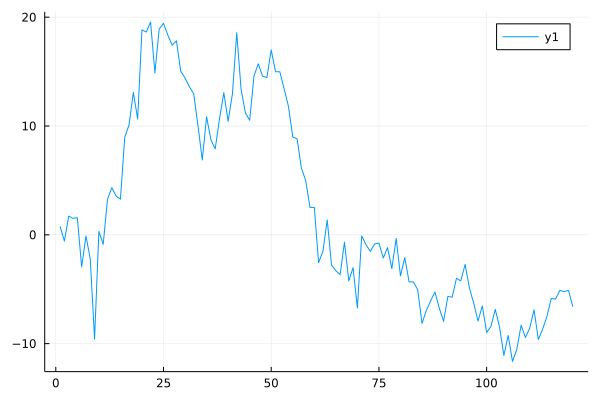

In [3]:
plot(y_data)

In [4]:
g = FactorGraph()

@RV M ~ Dirichlet([100 1 1; 1 100 1; 1 1 100]) # Dirichlet prior that disfavors frequent state transitions

z = Vector{Variable}(undef, T-1) # one-hot coding
s = Vector{Variable}(undef, T-1)
x = Vector{Variable}(undef, T)
y = Vector{Variable}(undef, T)

@RV z[1] ~ Categorical([0.333, 0.333, 0.334])
@RV x[1] ~ GaussianMeanVariance(0,1)
@RV y[1] ~ GaussianMeanVariance(x[1],1)
placeholder(y[1], :y, index=1)

f(z) = z[1]*w1 + z[2]*w2 + z[3]*w3
@RV s[1] ~ Nonlinear{Sampling}(z[1],g=f)

for t = 2:T-1
    @RV x[t] ~ GaussianMeanPrecision(x[t-1],s[t-1])
    @RV y[t] ~ GaussianMeanVariance(x[t],1)
    @RV z[t] ~ Transition(z[t-1],M)
    @RV s[t] ~ Nonlinear{Sampling}(z[t],g=f)
    
    placeholder(y[t], :y, index=t)
end;

@RV x[T] ~ GaussianMeanPrecision(x[T-1],s[T-1])
@RV y[T] ~ GaussianMeanVariance(x[T],1)
placeholder(y[T], :y, index=T)
;

In [5]:
# Define posterior factorization
pfz = PosteriorFactorization()
q_M = PosteriorFactor(M, id=:M)

q_z = Vector{PosteriorFactor}(undef, T-1)
q_x = Vector{PosteriorFactor}(undef, T)
for t=1:T-1
    q_z[t] = PosteriorFactor(z[t],id=:Z_*t)
    q_x[t] = PosteriorFactor(x[t],id=:X_*t)
end
q_x[T] = PosteriorFactor(x[T],id=:X_*T)

# Compile algorithm
algo_mf = messagePassingAlgorithm(id=:MF, free_energy=true)

# Generate source code
code_mf = algorithmSourceCode(algo_mf, free_energy=true);

# Load algorithm
eval(Meta.parse(code_mf));

In [6]:
# Initialize data
data = Dict(:y => y_data)
n_its = 20

# Initial posterior factors
marginals_mf = Dict{Symbol, ProbabilityDistribution}(:M => vague(Dirichlet, (3,3)))
for t = 1:T-1
    marginals_mf[:z_*t] = ProbabilityDistribution(Univariate, Categorical, p=[0.333,0.333,0.334])
    marginals_mf[:s_*t] = vague(SampleList)
    marginals_mf[:x_*t] = vague(GaussianMeanPrecision)
end
marginals_mf[:x_*T] = vague(GaussianMeanPrecision)

# Run algorithm
F_mf = Vector{Float64}(undef, n_its)
for i = 1:n_its
    stepMFM!(data, marginals_mf)
    for k = 1:T
        step!(:MFX_*k, data, marginals_mf)
    end
    for k = 1:T-1
        step!(:MFZ_*k, data, marginals_mf)
    end
    F_mf[i] = freeEnergyMF(data, marginals_mf)
end
;

In [7]:
marginals_mf[:M]

Dir(a=[[1.08e+02, 2.03, 1.00][2.03, 1.57e+02, 2.04][1.01, 2.03, 1.49e+02]])


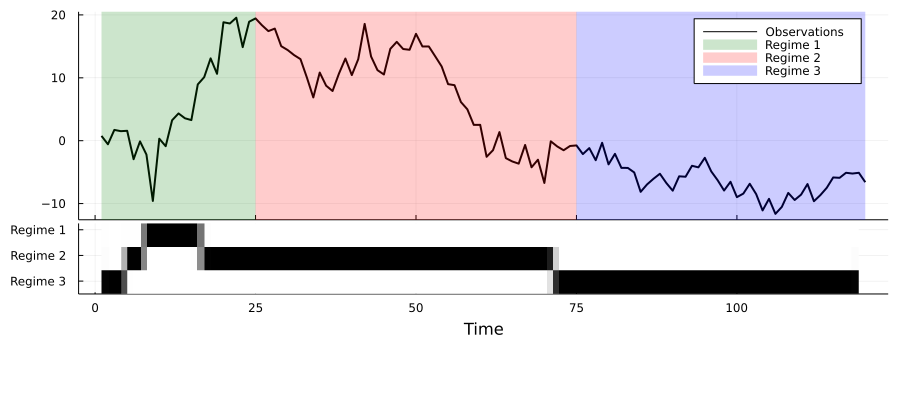

In [8]:
m_z = zeros(3,T-1)
for t=1:T-1
    m_z[:,t] = mean(marginals_mf[:z_*t])
end

estimate = zeros(12,T-1)
for i=1:4
    estimate[i,:] = 1. .- m_z[1,:]
    estimate[i+4,:] = 1. .- m_z[2,:]
    estimate[i+8,:] = 1. .- m_z[3,:]
end

gr()
l = @layout [a ; b]
mm=Plots.PlotMeasures.mm
p1 = plot(1:T, y_data, w=2, labels = "Observations", legend=(:best), color=:black)
vspan!(p1,[1,25], color = :green, alpha = 0.2, labels = "Regime 1");
vspan!(p1,[25,75], color = :red, alpha = 0.2, labels = "Regime 2");
vspan!(p1,[75,T], color = :blue, alpha = 0.2, labels = "Regime 3");

p2 = plot(Gray.(estimate), link=:x, xlabel="Time", top_margin=-25.0mm)
yticks!([2:4:10;], ["Regime 1", "Regime 2", "Regime 3"])

p = plot(p1, p2, layout = l, size = (900, 400))

In [9]:
writedlm("FLestimatesMF.txt", estimate)

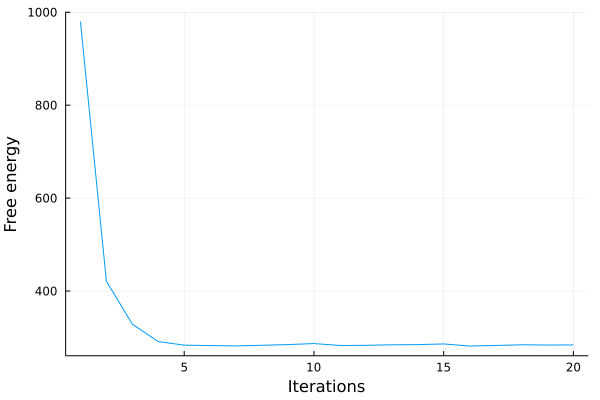

In [10]:
plot(F_mf, legend=false)
ylabel!("Free energy")
xlabel!("Iterations")

In [11]:
writedlm("FreeEnergyMF.txt", F_mf)

In [12]:
m_x = zeros(T)
v_x = zeros(T)
for t=1:T
    m_x[t] = mean(marginals_mf[:x_*t])
    v_x[t] = var(marginals_mf[:x_*t])
end

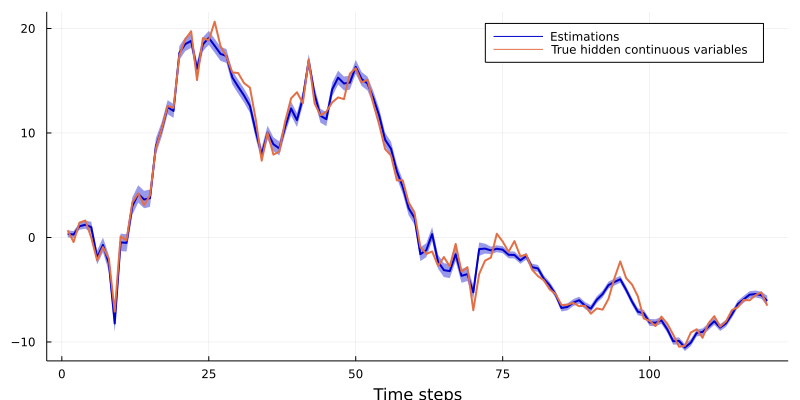

In [13]:
plot(m_x, ribbon=v_x, fillalpha=0.4, lw=2, size = (800, 400), color=:blue3, label="Estimations")
plot!(x_data, label="True hidden continuous variables", lw=2)
xlabel!("Time steps")

In [14]:
writedlm("FLContinuousMeanestimatesMF.txt", m_x)
writedlm("FLContinuousVarestimatesMF.txt", v_x)